<a href="https://colab.research.google.com/github/HexQuant/exx/blob/main/uncertainty_error_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор параметрической неопределённости методами Монте-Карло

Стандарты по оценке неопределённости:
* ГОСТ 34100.3.1-2017
* SO/IEC GUIDE 98-3:2008

In [154]:
# Загрузка нужных библиотек
from scipy import stats, interpolate
import numpy as np
from numpy.random import random
from matplotlib import pyplot as plt 
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd

plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
# Получение доступа к гугл диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Загрузка данных из Экселя
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PKS_OC.xlsx', sheet_name='data')
# Удалить пустые записи
df.dropna(inplace=True)
# Нормализация значения вероятности [0...1]
df['F(x)']=df['F(x)']/df['F(x)'].max()
# Показать несколько первых строк
df.head()

,calc,var,x,F(x)
0,CDF_JNB56_TNFD,Pc(AS),2.001000e-12,0.00
1,CDF_JNB56_TNFD,Pc(AS),1.815000e-11,0.01
2,CDF_JNB56_TNFD,Pc(AS),2.815000e-11,0.02
3,CDF_JNB56_TNFD,Pc(AS),3.711000e-11,0.03
4,CDF_JNB56_TNFD,Pc(AS),4.464000e-11,0.04


In [107]:
inv_cdf = {}

calc_group = df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  var_dic = {}
  var_group = calc_df.groupby(by=['var'])
  
  for var_name, var_df in var_group:
    #print(calc_name, var_name)
    # Строим линейную интерполяцию инвертированной CDF. В результате получаем функцию.
    var_dic[var_name] = interpolate.interp1d(var_df['F(x)'],var_df['x'])

  inv_cdf[calc_name] = var_dic

In [151]:
# Генерируем случайные значения на оснорве эмперической CDF (https://en.wikipedia.org/wiki/Inverse_transform_sampling

# Количество семплов
N=int(1e+6)
samples_df = pd.DataFrame()
for calc_item in inv_cdf.items():
  for var_item in calc_item[1].items():
    # Генерируем N случайных значений (непрерывное равномерное распределение [0...1])
    uniform_samples = random(N)
    #print(calc_item[0])
    #print(var_item[1])
    samples_df = samples_df.append(pd.DataFrame({
        'calc':calc_item[0],
        'var':var_item[0],
        'value':var_item[1](uniform_samples)}))

In [152]:
samples_df.head()

,calc,var,value
0,CDF_JNB56-57_TCLIE,Fc00,1.047962e-07
1,CDF_JNB56-57_TCLIE,Fc00,3.677460e-08
2,CDF_JNB56-57_TCLIE,Fc00,1.630450e-08
3,CDF_JNB56-57_TCLIE,Fc00,5.016353e-07
4,CDF_JNB56-57_TCLIE,Fc00,5.159827e-07


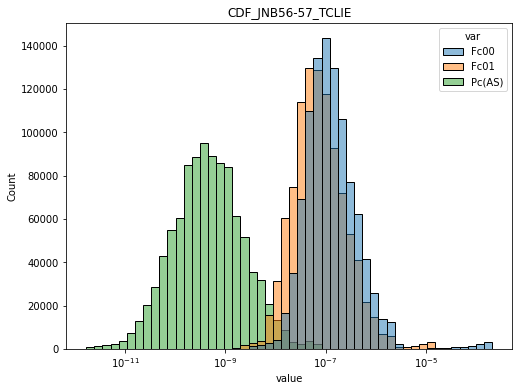

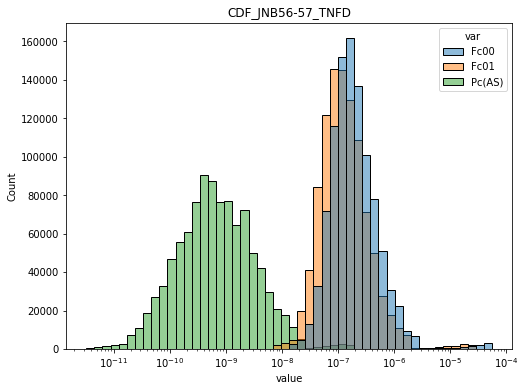

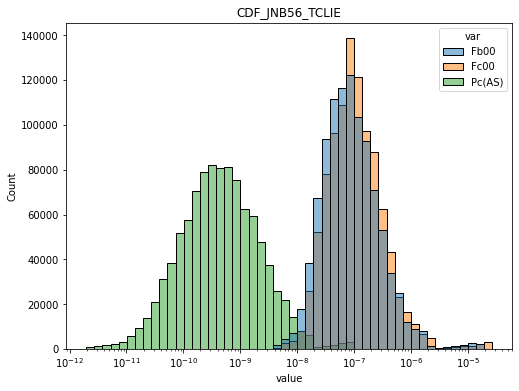

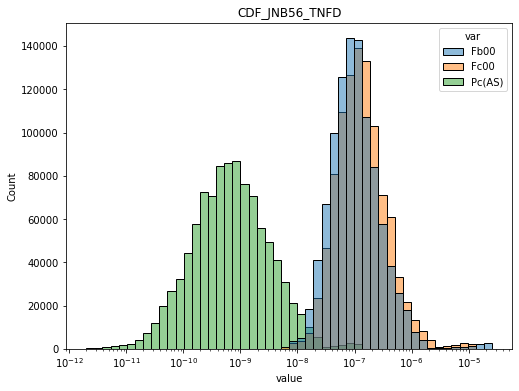

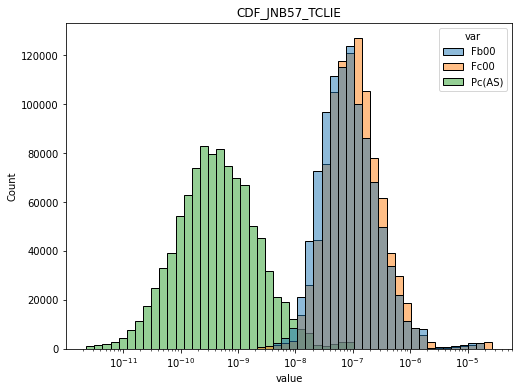

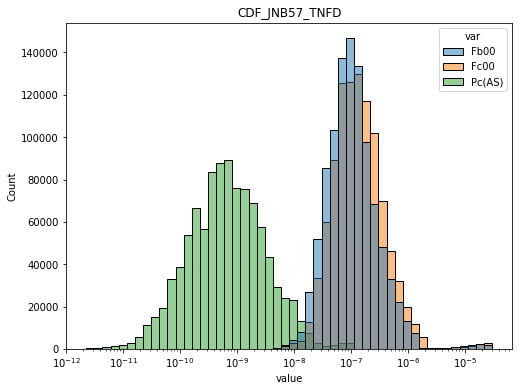

In [155]:
# Строим гитограммы полученных значений
calc_group = samples_df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  ax = sns.histplot(calc_df,x='value', hue='var', log_scale=True, bins=50)
  ax.set_title(calc_name)
  plt.show()

Формула 1.6.5:
$$t_b = \frac{P_c(AS)}{F_c^{00}-F_b^{00}}$$

In [113]:
def f165(P_cas, F_c, F_b):
  a =  F_c - F_b
  a = np.where(a > 1e-10, a, 1e-10)
  a =  P_cas/(F_c-F_b)
  return a

In [162]:
v165 = {}
calc_group = samples_df.groupby(by=['calc'])
for calc_name, calc_df in calc_group:
  v = f165(calc_df[calc_df['var']=='Pc(AS)']['value'],
                         calc_df[calc_df['var']=='Fc00']['value'],
                         calc_df[calc_df['var']=='Fb00']['value'])
  ci = 95
  truncation = 100-ci #99.73 # Отсечение в %, -1.3 соотвествует 3*sigma
  
  p5, p95 = np.percentile(v,[truncation/2, 100 - truncation/2 ])
  # p5, p95 = v165.mean() - 3 * v165.std(), v165.mean() + 3 * v165.std()
  v = v[(v>=p5) & (v<=p95)]
  print(p5,p95)
  v165[calc_name] = v

nan nan
nan nan
-0.19917622336766772 0.22015446636685365
-0.24580372625961844 0.27305005969056284
-0.19267457368637814 0.2200184125957545
-0.24005177994165278 0.257999791995448


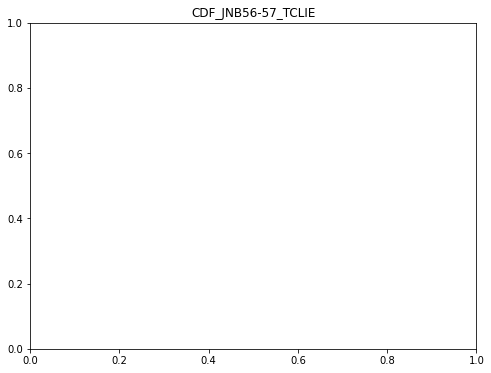

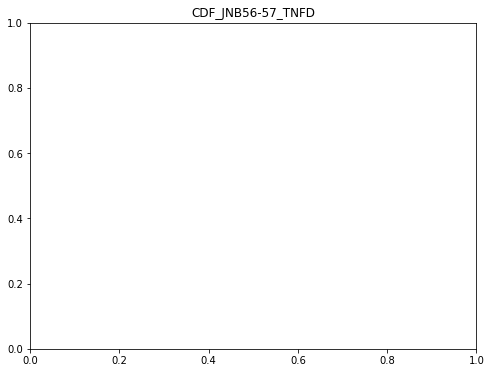

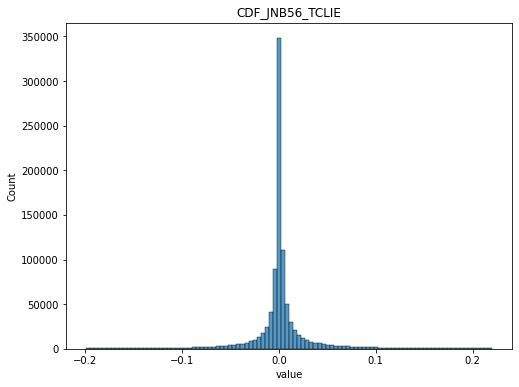

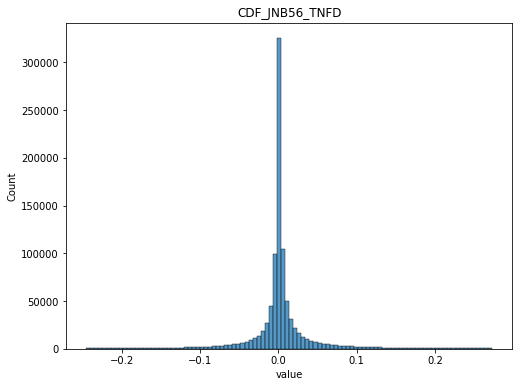

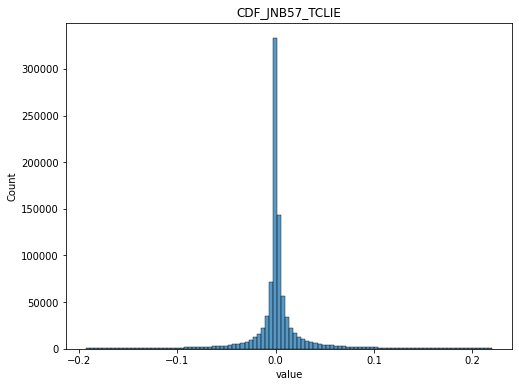

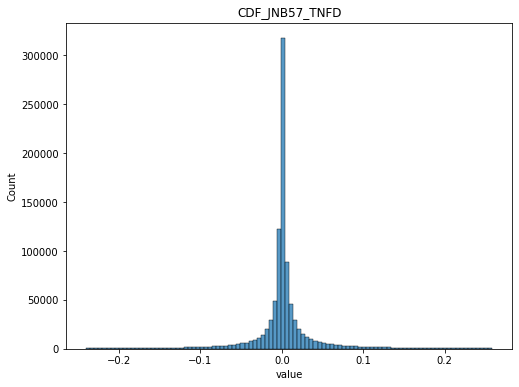

In [163]:
for item in v165.items():
  v = item[1]
  name = item[0]
  ax = sns.histplot(v,bins=100)
  ax.set_title(name)
  #plt.xlim(-3,3)
  #plt.yscale('log')
  plt.show()

In [175]:
import scipy.stats as st
from tqdm import tqdm

def fit_scipy_distributions(array, bins, plot_hist = True, plot_best_fit = True, plot_all_fits = False):
  if plot_best_fit or plot_all_fits:
    assert plot_hist, "plot_hist must be True if setting plot_best_fit or plot_all_fits to True"
  
  # Returns un-normalised (i.e. counts) histogram
  y, x = np.histogram(array, bins=bins)
    
  # Some details about the histogram
  bin_width = x[1]-x[0]
  N = len(array)
  x_mid = (x + np.roll(x, -1))[:-1] / 2.0 # go from bin edges to bin middles
  
  # selection of available distributions
  # CHANGE THIS IF REQUIRED
  #DISTRIBUTIONS = [st.alpha,st.cauchy,st.cosine,st.laplace,st.levy,st.levy_l,st.norm]
  DISTRIBUTIONS = [st.norm, st.lognorm, st.laplace, st.cauchy]
  
  if plot_hist:
      fig, ax = plt.subplots()
      #plt.yscale("log")
      #h = sns.histplot(np.array(array), bins = bins, ax=ax)
      h = ax.hist(array, bins = bins)

  # loop through the distributions and store the sum of squared errors
  # so we know which one eventually will have the best fit
  sses = []
  for dist in DISTRIBUTIONS:
      name = dist.__class__.__name__[:-4]

      params = dist.fit(array)
      arg = params[:-2]
      loc = params[-2]
      scale = params[-1]

      pdf = dist.pdf(x_mid, loc=loc, scale=scale, *arg)
      pdf_scaled = pdf * bin_width * N # to go from pdf back to counts need to un-normalise the pdf

      sse = np.sum((y - pdf_scaled)**2)
      sses.append([sse, name])

      # Not strictly necessary to plot, but pretty patterns
      if plot_all_fits:
          ax.plot(x_mid, pdf_scaled, label = name)
  
  if plot_all_fits:
      plt.legend(loc=1)

  # CHANGE THIS IF REQUIRED
  ax.set_xlabel('x label')
  ax.set_ylabel('y label')

  # Things to return - df of SSE and distribution name, the best distribution and its parameters
  results = pd.DataFrame(sses, columns = ['SSE','distribution']).sort_values(by='SSE') 
  best_name = results.iloc[0]['distribution']
  best_dist = getattr(st, best_name)
  best_params = best_dist.fit(array)
  
  if plot_best_fit:
      new_x = np.linspace(x_mid[0] - (bin_width * 2), x_mid[-1] + (bin_width * 2), 1000)
      best_pdf = best_dist.pdf(new_x, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
      best_pdf_scaled = best_pdf * bin_width * N
      ax.plot(new_x, best_pdf_scaled, label = best_name)
      plt.legend(loc=1)
  
  if plot_hist:
      plt.show()

    
  return results, best_name, best_params

In [ ]:
sses, best_name, best_params = fit_scipy_distributions(v165['CDF_JNB57_TNFD'],
                                                       bins = 100,
                                                       plot_best_fit = False, 
                                                       plot_all_fits=True)

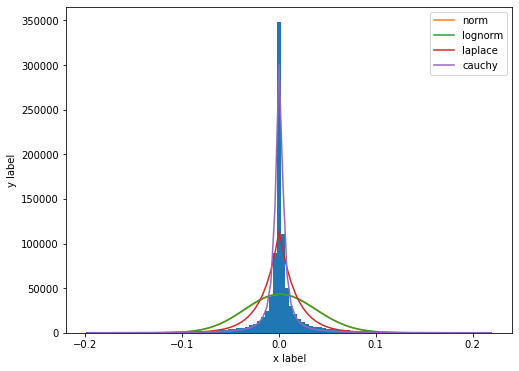

CDF_JNB56_TCLIE cauchy (0.0003492261563857685, 0.004186766338492643)             SSE distribution
3  8.193330e+09       cauchy
2  6.151224e+10      laplace
1  1.075597e+11      lognorm
0  1.076816e+11         norm


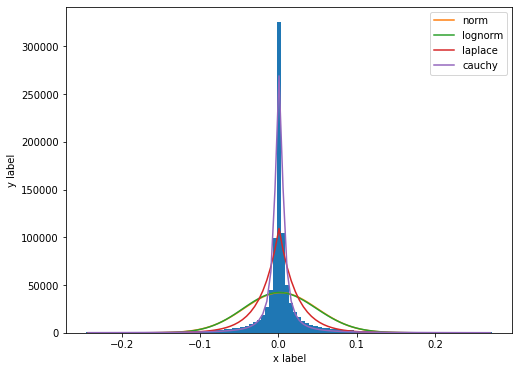

CDF_JNB56_TNFD cauchy (0.0006950477989422764, 0.005831609300923848)             SSE distribution
3  8.664177e+09       cauchy
2  5.248609e+10      laplace
1  9.465183e+10      lognorm
0  9.475352e+10         norm


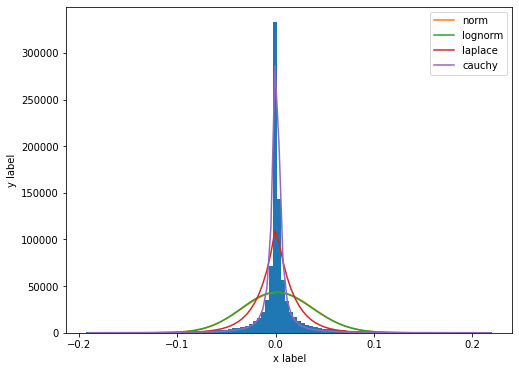

CDF_JNB57_TCLIE cauchy (0.00040691126376514285, 0.004010420645472062)             SSE distribution
3  7.963002e+09       cauchy
2  5.850408e+10      laplace
1  1.028030e+11      lognorm
0  1.029974e+11         norm


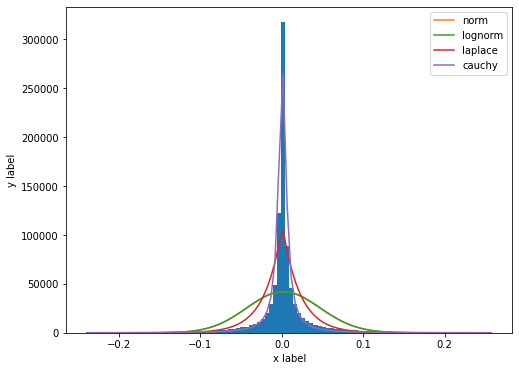

CDF_JNB57_TNFD cauchy (0.0007208071383404974, 0.005564858849068389)             SSE distribution
3  7.857104e+09       cauchy
2  5.166263e+10      laplace
1  9.205408e+10      lognorm
0  9.210835e+10         norm


In [177]:
for v in v165.items():
  if len(v[1])!=0:
    sses, best_name, best_params = fit_scipy_distributions(v[1],
                                                       bins = 100,
                                                       plot_best_fit = False, 
                                                       plot_all_fits=True)
    print(v[0], best_name, best_params, sses)

(0.010202065392601007, 0.3925968480100975)
(0.0018645311227860253, 0.011139666552419634)


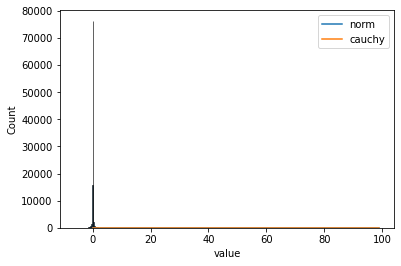

In [ ]:
dist_names = ['norm', 'cauchy']

size = 100
x = np.linspace(-500,500,100)
#h = plt.hist(v165, bins=range(48))

sns.histplot(v165, bins=50)
#plt.xscale('symlog')
#plt.yscale('log')
for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    params = dist.fit(v165)
    print(params)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale)*size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=loc)*size
    plt.plot(pdf_fitted, label=dist_name)
    #plt.xlim(-3,3)
    
plt.legend(loc='upper right')

In [ ]:
a, b = 1., 2.
x = stats.beta.rvs(a, b, size=1000)
x

array([4.42483773e-02, 1.80476626e-01, 3.35512490e-01, 1.79223207e-02,
       4.43890510e-01, 1.56257773e-01, 8.82542514e-01, 4.61620345e-01,
       2.14039830e-01, 3.82442684e-01, 7.00797837e-01, 3.67385454e-01,
       1.09352444e-01, 3.01901259e-02, 8.84567984e-02, 1.70865170e-03,
       6.21995107e-02, 8.92428537e-02, 5.26353922e-01, 3.88483127e-01,
       2.65426734e-01, 3.61971630e-01, 6.34392509e-01, 2.81502966e-01,
       6.63772056e-01, 1.96688626e-01, 3.27451228e-01, 4.13598484e-01,
       4.98950117e-01, 3.63219769e-01, 1.75018607e-01, 2.49727826e-01,
       3.06474184e-01, 3.86053691e-01, 3.35884167e-01, 5.62760687e-01,
       1.79583687e-01, 3.23021516e-01, 1.23834769e-01, 3.38303741e-01,
       3.36000911e-01, 3.17466957e-02, 7.14316532e-01, 8.21623492e-01,
       1.59135881e-01, 5.48170531e-01, 3.69651335e-01, 1.82970256e-01,
       8.12859824e-01, 4.05550360e-01, 1.31033647e-01, 4.15923531e-01,
       3.99447320e-01, 1.51900713e-01, 3.49060375e-02, 1.17004827e-01,
      

In [ ]:
x

array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18

In [ ]:
k=0.80327
mvnorm = stats.multivariate_normal([0, 0], [[1, k], [k, 1]])
x = mvnorm.rvs((N,))
norm = stats.norm([0],[1])
x_unif = norm.cdf(x)
x_unif = x_unif[x_unif[:,0]>x_unif[:,1]]
P_cas = inv_cdf['Pc(AS)'](random(x_unif.shape[0]))
F_c00 = inv_cdf['Fc00'](x_unif[:,0])
F_b00= inv_cdf['Fb00'](x_unif[:,1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


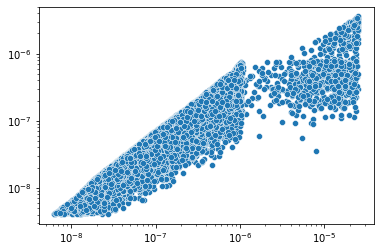

In [ ]:
ax = sns.scatterplot(F_c00,F_b00)
ax.set_yscale('log')
ax.set_xscale('log')

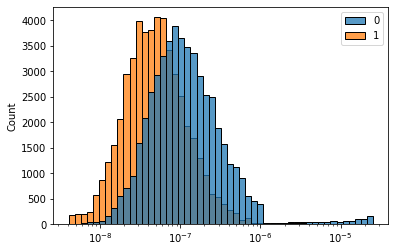

In [ ]:
sns.histplot([F_c00, F_b00], log_scale=True, bins=50)

In [ ]:
v165_2 = f165(P_cas,F_c00,F_b00)

0.009438156214075937 0.08924766718730685


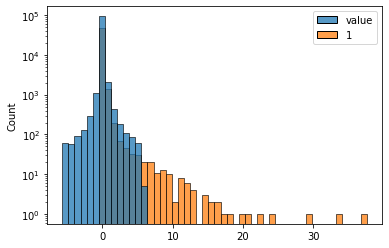

In [ ]:
print(np.mean(v165), np.mean(v165_2))
sns.histplot((v165, v165_2), bins=50)
plt.yscale('log')

In [ ]:
shape, loc, scale = stats.norm.fit(v165)
x = np.linspace(-10, 10, 100)
pdf = stats.lognorm.pdf(x, shape, loc, scale)

ax = sns.lineplot(x, pdf)

ax.set_xscale('log')

ValueError: ignored

In [ ]:
pdf

array([4.11733303e-002, 4.11733293e-002, 4.11733282e-002, 4.11733268e-002,
       4.11733252e-002, 4.11733232e-002, 4.11733208e-002, 4.11733179e-002,
       4.11733145e-002, 4.11733103e-002, 4.11733052e-002, 4.11732992e-002,
       4.11732918e-002, 4.11732830e-002, 4.11732723e-002, 4.11732594e-002,
       4.11732439e-002, 4.11732250e-002, 4.11732023e-002, 4.11731747e-002,
       4.11731413e-002, 4.11731008e-002, 4.11730516e-002, 4.11729918e-002,
       4.11729188e-002, 4.11728296e-002, 4.11727204e-002, 4.11725861e-002,
       4.11724205e-002, 4.11722154e-002, 4.11719602e-002, 4.11716410e-002,
       4.11712393e-002, 4.11707306e-002, 4.11700817e-002, 4.11692477e-002,
       4.11681671e-002, 4.11667552e-002, 4.11648945e-002, 4.11624212e-002,
       4.11591055e-002, 4.11546234e-002, 4.11485168e-002, 4.11401347e-002,
       4.11285506e-002, 4.11124410e-002, 4.10899133e-002, 4.10582563e-002,
       4.10135830e-002, 4.09503196e-002, 4.08604775e-002, 4.07326237e-002,
       4.05504382e-002, 4

In [ ]:
v165

0        0.006073
1       -0.005963
2        0.003486
3        0.065255
4        0.000226
           ...   
49995    0.000934
49996    0.029848
49997    0.035018
49998   -0.001786
49999    0.004345
Name: value, Length: 50000, dtype: float64

In [ ]:
y_pdf

0.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


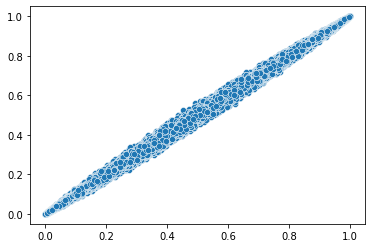

In [ ]:
sns.scatterplot(x_unif[:,0],x_unif[:,1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


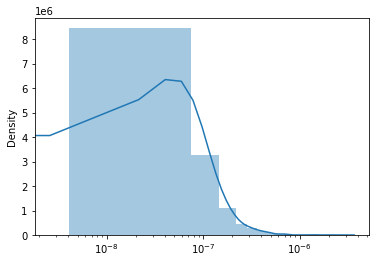

In [ ]:
sns.distplot(r['Fb00'])
plt.xscale('log')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[None]

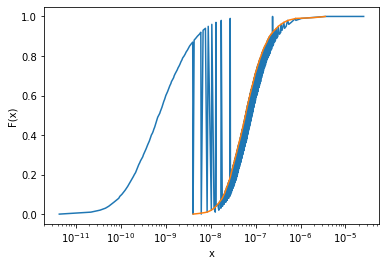

In [ ]:
# Сравнить распределения
g_results = sns.lineplot(df['x'], df['F(x)'])
g_results = sns.lineplot(required_samples, uniform_samples)
g_results.set(xscale='log')

In [ ]:
a = f165(r['Pc(AS)'],r['Fc00'],r['Fb00'])
a.

SyntaxError: ignored

In [ ]:
#print(a)
#sns.displot(a)
plt.hist(a, bins= 200)

In [ ]:
g = sns.JointGrid(x=r['Fc00'],y=r['Fb00'])
g = g.plot_joint(plt.scatter,  edgecolor="white")

x_logbins = np.geomspace(r['Fc00'].min(),r['Fc00'].max(), num = 30)
g.ax_marg_x.hist(r['Fc00'], bins=x_logbins)

y_logbins = np.geomspace(r['Fb00'].min(),r['Fb00'].max(), num = 30)
g.ax_marg_y.hist(r['Fb00'], orientation='horizontal', bins=y_logbins)
#g.plot_marginals(sns.distplot, hist=True, kde=True, color='blue', bins=logbins)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
np.numpy.random.multivariate_normal()

In [ ]:
y_logbins

Формла 1.7.7:
$$ {(F}_c^{00}-F_b^{00})\cdot t_{so}+{(P}_c\left(AS\right)-P_b\left(AS\right))+{(F}_c^{01}-F_b^{01})\cdot T_{01}+{(F}_c^{02}-F_b^{02})\cdot T_{02}++{(F}_c^{03}-F_b^{03})\cdot T_{03}+{(P}_c\left(OD\right)-P_b\left(OD\right))+{(F}_c^{05}-F_b^{05})\cdot t_r={P_c\left(AS\right)+(F}_c^{01}-F_b^{00})\cdot T_{01}+{(F}_c^{02}-F_b^{00})\cdot T_{02}+{(F}_c^{03}-F_b^{00})\cdot T_{03}+P_c\left(OD\right)+{(F}_c^{04}-F_b^{00})\cdot t_r+{(F}_c^{09}-F_b^{00})\cdot T_{09}+{(F}_c^{10}-F_b^{00})\cdot T_{10}+{(F}_c^{11}-F_b^{00})\cdot T_{11}+{(F}_c^{12}-F_b^{00})\cdot T_{12}+{(F}_c^{13}-F_b^{00})\cdot T_{13}+{P_c\left(LOCA-JEF\right)}^\ast $$
Выразим из неё $t_{so}$

In [ ]:
from sympy import symbols, IndexedBase, Idx, Sum, Indexed
from sympy import simplify, solve
F_c = IndexedBase('F_c')
F_b = IndexedBase('F_b')
T = IndexedBase('T')
t_so, t_r, P_cas, P_bas, P_cod, P_bod, = symbols('t_{so} t_r P_{c}(AS) P_{b}(AS) P_{c}(OD) P_{b}(OD)')
P_cloca = symbols('P_{c}(LOCA-JEF)')
i, j = symbols('i j')
a = (P_cas-P_bas)+(F_c[1]-F_b[1])*t_so+Sum((F_c[i]-F_b[i])*T[i],(i,0,3))-(P_cod + P_bod)+(F_c[5]-F_b[5]) * t_r
b = P_cas+Sum((F_c[i]-F_b[0])*T[i],(i,0,3))+P_cod+(F_c[4]-F_b[0])*t_r+Sum((F_c[i]-F_b[0])*T[i],(i,9,13))+P_cloca

In [ ]:
a

In [ ]:
b

In [ ]:
solve(a-b, t_so)

$$ t_{so} = \frac{P_b\left(AS\right)+P_b\left(OD\right)+{P_c(LOCA-JEF)}^\ast}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{01})\cdot T_{01}}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{02})\cdot T_{02}}{F_c^{00}-F_b^{00}} - \frac{(F_b^{00}-F_b^{03})\cdot T_{03}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{04}-F_b^{00}-F_c^{05}+F_b^{05})\cdot t_r}{F_c^{00}-F_b^{00}} + \frac{(F_c^{09}-F_b^{00})\cdot T_{09}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{10}-F_b^{00})\cdot T_{10}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{11}-F_b^{00})\cdot T_{11}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{11}-F_b^{00})\cdot T_{11}}{F_c^{00}-F_b^{00}}  + \frac{(F_c^{12}-F_b^{00})\cdot T_{12}}{F_c^{00}-F_b^{00}} + \frac{(F_c^{13}-F_b^{00})\cdot T_{13}}{F_c^{00}-F_b^{00}} $$


In [ ]:
def t_so():
    Fb = [uniform.rvs(size=batch_size) for i in range(6)]
    Fc = [uniform.rvs(size=batch_size) for i in range(14)]
    T = [uniform.rvs(size=batch_size) for i in range(14)]
    T = [uniform.rvs(size=batch_size) for i in range(14)]
    Tr = uniform.rvs(size=batch_size)
    
    t =(
        (Fb[0]-Fb[1])*T[1]-
        (Fb[0]-Fb[2])*T[2]-
        (Fb[0]-Fb[3])*T[3]+
        (Fc[4]-Fb[0]-Fc[5]-Fb[5])*Tr+
        (Fc[9]-Fb[0])*T[9]+
        (Fc[10]-Fb[0])*T[10]+
        (Fc[11]-Fb[0])*T[11]+
        (Fc[11]-Fb[0])*T[11]+ # Повторение, описка?
        (Fc[12]-Fb[0])*T[12]+
        (Fc[13]-Fb[0])*T[13]
    )/(Fc[0]-Fb[0])
    return t

$$ F_a^{00}\cdot t_{so}+P_a\left(AS\right)+F_a^{01} \cdot T_{01}+F_a^{02}\cdot T_{02}+F_a^{03}\cdot T_{03}+P_a\left(OD\right)+F_a^{05}\cdot t_r $$

In [ ]:
def f172():
  Fa = [uniform.rvs(size=batch_size) for i in range(6)]
  T = [uniform.rvs(size=batch_size) for i in range(4)]
  t_so = uniform.rvs(size=batch_size)
  tr = uniform.rvs(size=batch_size)
  Pas = uniform.rvs(size=batch_size)
  Pod = uniform.rvs(size=batch_size)


## Численный подход

### Тупо брутфорс
Предполагается, что все переменные попарно независимы

In [ ]:
batch_count = 10**2
batch_size = 10**2
d = np.zeros(batch_count*batch_size)
for i in range(batch_count):
    
    d[batch_size*i:batch_size*(i+1)] = t_so()

In [ ]:
sns.histplot(d, bins = 10)

In [ ]:
dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

'''
dist_names = [ 
    'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma',
    'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r',
    'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic',
    'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma',
    'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace',
    'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw',
    'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang',
    'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
'''

In [ ]:
import scipy
import scipy.stats

size = 10000
x = np.arange(size)

sns.histplot(d, bins = 10)

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(d)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=loc) * size
    plt.plot(pdf_fitted, label=dist_name)
    #plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

### Алгоритм Монте-Карло по схеме марковских цепей (MCMC)




## Символьный подход

In [ ]:
d.shape[0]

$ F_a^{00}, F_a^{01}, F_a^{03}, F_a^{04}, F_a^{09}, F_a^{10} $ -добавленная частота повреждения ядерного топлива/большого аварийного выброса в ЭСС00, ЭСС01, ЭСС03, ЭСС04, ЭСС09, ЭСС10 соответственно

In [ ]:
Fa00, Fa01, Fa03, Fa04, Fa09, Fa10  = [uniform.rvs(size=batch_size) for i in range(6)]
Fb00, Fb01, Fb02, Fb03 = [uniform.rvs(size=batch_size) for i in range(4)]
Fc02, Fc11, Fc12, Fc13 = [uniform.rvs(size=batch_size) for i in range(4)]
T01,T02,T03,T09,T10,T11,T12,T13  = [uniform.rvs(size=batch_size) for i in range(8)]


$ F_b^{00} $ – базовая частота повреждения ядерного топлива/большого аварийного выброса в ЭСС00

$ F_c^{02}, F_c^{11}, F_c^{12}, F_c^{13} $ – текущая частота повреждения ядерного топлива/большого аварийного выброса в ЭСС02, ЭСС11, ЭСС12, ЭСС13

$ T_{01}, T_{02}, T_{03}, T_{09}, T_{10}, T_{11}, T_{12}, T_{13} $  – длительность ЭСС01, ЭСС02, ЭСС03, ЭСС09, ЭСС10, ЭСС11, ЭСС12, ЭСС13 соответственно

In [ ]:
t =(
    (Fb00-Fb01)*T01-
    (Fb00-Fb02)*T02-
    (Fb00-Fb03)*T03+
    (Fc04-Fb00-Fc05-Fb05)*Tr+
    (Fc09-Fb00)*T09+
    (Fc10-Fb00)*T10+
    (Fc11-Fb00)*T11+
    (Fc11-Fb00)*T11+
    (Fc12-Fb00)*T12+
    (Fc13-Fb00)*T13
)/(Fc00-Fb00)



In [ ]:
t =(
    (Fb[0]-Fb[1])*T[1]-
    (Fb[0]-Fb[2])*T[2]-
    (Fb[0]-Fb[3])*T[3]+
    (Fc[4]-Fb[0]-Fc[5]-Fb[5])*Tr+
    (Fc[9]-Fb[0])*T[9]+
    (Fc[10]-Fb[0])*T[10]+
    (Fc[11]-Fb[0])*T[11]+
    (Fc[11]-Fb[0])*T[11]+
    (Fc[12]-Fb[0])*T[12]+
    (Fc[13]-Fb[0])*T[13]
)/(Fc[0]-Fb[0])




In [ ]:
t

In [ ]:
T[1,4:5]=[1,2,3]

In [ ]:
T

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


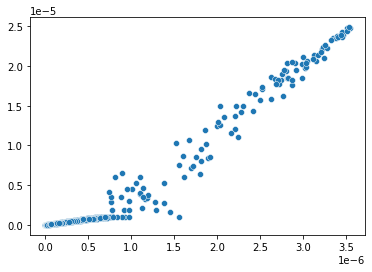

In [ ]:
sns.scatterplot(F_b00,F_c00)

In [ ]:
a = P_cas/(F_c00-F_b00)
a.mean()

0.18995958696743168

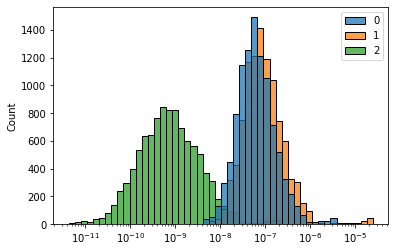

In [ ]:
sns.histplot([F_b00, F_c00, P_cas], bins=50, log_scale=True, )

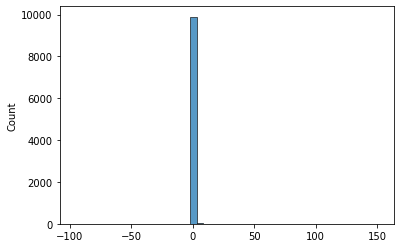

In [ ]:
sns.histplot(a, bins=50 )

In [ ]:
a.mean()

0.2091216953939047